In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [19]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\EEG EPs all trials'

### Load subjects .csv

In [6]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_05.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [7]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
0,psilocybin,676727,aw_psi_2023-05-10_09-49-12,"awake,psilocybin,psilocybin",deep,29,True,F:\psi_exp\mouse676727\aw_psi_2023-05-10_09-49...,25,only has one estim current
1,isoflurane,676727,aw_iso_2023-05-11_09-44-46,"awake,isoflurane",deep,29,True,F:\psi_exp\mouse676727\aw_iso_2023-05-11_09-44...,25,only has one estim current
2,urethane,676727,urethane_2023-05-12_11-35-38,urethane,deep,29,True,F:\psi_exp\mouse676727\urethane_2023-05-12_11-...,25,only has one estim current
3,psilocybin,689242,aw_psi_2023-07-19_10-29-49,"awake,psilocybin,psilocybin",deep,"13,16",True,F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29...,25,NaN
4,isoflurane,689242,aw_iso_2023-07-20_10-52-57,"awake,isoflurane",deep,13,True,F:\psi_exp\mouse689242\aw_iso_2023-07-20_10-52...,25,NaN


### Multi-subject loop

#### Get EEG traces for all states/estim

In [8]:
StimType = 'biphasic'

In [9]:
allsubs = np.unique(subject_df.mouse.values)

all_info = {}
for mousei in allsubs:
    print(mousei)
    all_info[mousei] = {}
    mouse_df = subject_df[subject_df['mouse'] == mousei]
    
    for dfind, subrow in mouse_df.iterrows():
        print(' {}'.format(subrow.experiment))
        all_info[mousei][subrow.exp_type] = {'info': {}, 'EEG_traces': {}}
        subexp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
        
        ## Grab exp metadata from Templeton-log_exp ##
        exp_meta = metadata[(
            (metadata['mouse_name'].str.contains(subrow.mouse)) &
            (metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()

        ## Get injection times ##
        if subrow.exp_type in ['psilocybin', 'ketanserin']:
            inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        else:
            print('  This {} experiment has no injection times.'.format(subrow.exp_type))
            inj_times = None
            
        ## Load stim log and apply sweep labels ##
        stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
        ### Get state label for each sweep ###
        all_sweeps = np.unique(stim_log['sweep'].values)
        sweep_state_list = []
        for char in subrow.sweep_states.split(','):
            sweep_state_list.append(char)
        if len(sweep_state_list) == 1:
            sweep_state_list = sweep_state_list * len(all_sweeps)
        stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
        ### Get list of states and the middle current ###
        states = np.unique(stim_log['state'].values)
        currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
        if len(currents) > 1:
            estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
        else:
            estim_current = {'mid': str(currents[0])}
            
        ## Get bad EEG channels ##
        badchstr = subrow.bad_chs.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        all_info[mousei][subrow.exp_type]['info']['good_chs'] = GOOD_CHS
        all_info[mousei][subrow.exp_type]['info']['trial_count'] = {}
        
        ## Get event traces ##
        estimlog = stim_log[stim_log['stim_type'] == StimType]
        for statei in states:
            all_info[mousei][subrow.exp_type]['EEG_traces'][statei] = {}
            all_info[mousei][subrow.exp_type]['info']['trial_count'][statei] = {}

            for clevel, parami in estim_current.items():
                event_inds = get_events_wdict(estimlog, {'state': statei, 'parameter': parami}, out='index')
                event_traces = all_EEG_traces[:, :, event_inds]
                ## Apply common average reference ##
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                all_info[mousei][subrow.exp_type]['EEG_traces'][statei][clevel] = [EEG_event_timestamps, event_traces]
                all_info[mousei][subrow.exp_type]['info']['trial_count'][statei][clevel] = len(event_inds)
    print('')

676727
 aw_psi_2023-05-10_09-49-12
Experiment type: electrical and sensory stimulation
 aw_iso_2023-05-11_09-44-46
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 urethane_2023-05-12_11-35-38
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

689239
 aw_iso_2023-08-09_11-15-42
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 aw_psi_2023-08-10_11-26-36
Experiment type: electrical stimulation
 urethane_2023-08-11_11-33-46
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

689242
 aw_psi_2023-07-19_10-29-49
Experiment type: electrical and sensory stimulation
 aw_iso_2023-07-20_10-52-57
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 urethane_2023-07-21_12-32-25
Experiment type: electrical and sensory stimulation
  

#### Plot some EPs

<IPython.core.display.Javascript object>


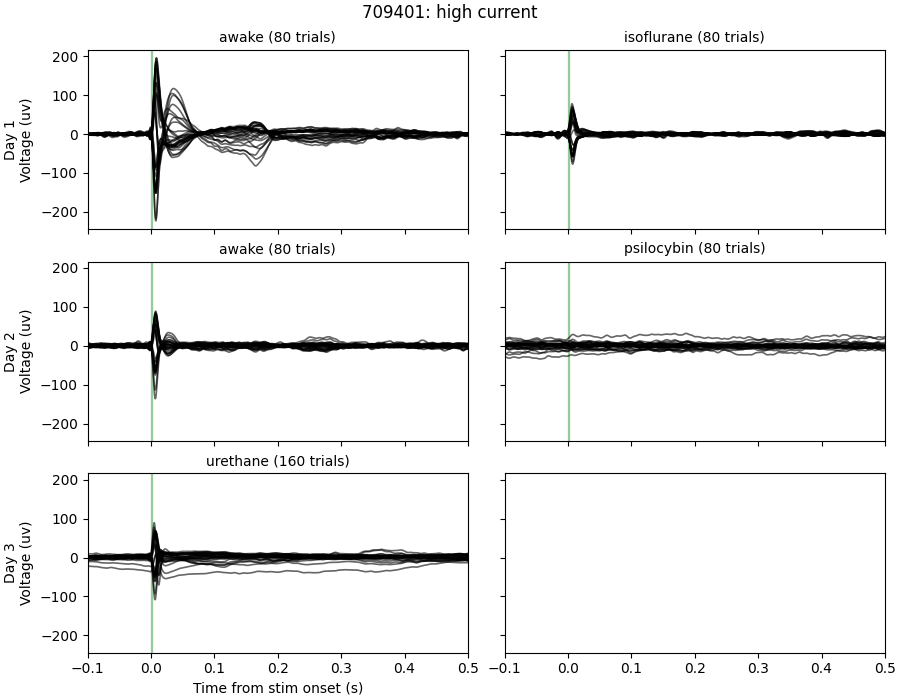

Text(0.5, 0.98, '709401: high current')

In [18]:
subsub = '709401'
pcurr = 'high'
plot_window = [-0.1, 0.5]

exp_num = len(all_info[subsub])
fig, axs = plt.subplots(exp_num, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)

for rowi, (expday, expdict) in enumerate(all_info[subsub].items()):
    good_chs = expdict['info']['good_chs']
    for coli, (statei, stdict) in enumerate(expdict['EEG_traces'].items()):
        
        timex = stdict[pcurr][0]
        ep = np.mean(stdict[pcurr][1], axis=2)

        axs[rowi,coli].axvspan(0, 0.002, color='g', alpha=0.3)
        axs[rowi,coli].plot(timex, ep[:, good_chs], 'k', linewidth=1.2, alpha=0.6)
        axs[rowi,coli].set_title('{} ({:d} trials)'.format(statei, expdict['info']['trial_count'][statei][pcurr]))
        
        if coli == 0:
            axs[rowi,coli].set_ylabel('Day {:d}\nVoltage (uv)'.format(rowi+1))

        
axs[rowi,coli].set_xlim([-0.1, 0.5])
axs[rowi,coli].set_xlabel('Time from stim onset (s)')

fig.suptitle('{}: {} current'.format(subsub, pcurr))

## Save ##
figname = '{}_{}_EPs_alltrials.png'.format(subsub, pcurr)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [ ]:
plot_window = [-0.1, 0.5]
for mousei in allsubs:
    for pcurr in ['low', 'mid', 'high']:
        exp_num = len(all_info[mousei])
        fig, axs = plt.subplots(exp_num, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)

        for rowi, (expday, expdict) in enumerate(all_info[mousei].items()):
            good_chs = expdict['info']['good_chs']
            for coli, (statei, stdict) in enumerate(expdict['EEG_traces'].items()):
                if pcurr not in stdict.keys():
                    break

                timex = stdict[pcurr][0]
                ep = np.mean(stdict[pcurr][1], axis=2)

                axs[rowi,coli].axvspan(0, 0.002, color='g', alpha=0.3)
                axs[rowi,coli].plot(timex, ep[:, good_chs], 'k', linewidth=1.2, alpha=0.6)
                axs[rowi,coli].set_title('{} ({:d} trials)'.format(statei, expdict['info']['trial_count'][statei][pcurr]))

                if coli == 0:
                    axs[rowi,coli].set_ylabel('Day {:d}\nVoltage (uv)'.format(rowi+1))


        axs[rowi,coli].set_xlim([-0.1, 0.5])
        axs[rowi,coli].set_xlabel('Time from stim onset (s)')

        fig.suptitle('{}: {} current'.format(mousei, pcurr))

        ## Save ##
        figname = '{}_{}_EPs_alltrials.png'.format(mousei, pcurr)
#         fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Calculating ERP metrics

In [27]:
subject = '666194'
day = 'saline'
stim = 'biphasic'
zlim = 3

good_chs = subjects_data[subject][day]['good_chs']
EEG_sample_rate = subjects_data[subject][day]['exp'].ephys_params['EEG']['sample_rate']

for curri, sweepdict in subjects_data[subject][day]['EEG_traces'][stim].items():
    sweep_info = subjects_data[subject][day]['sweep_info_df'][
        (subjects_data[subject][day]['sweep_info_df']['stim'] == stim) &
        (subjects_data[subject][day]['sweep_info_df']['parameter'] == curri)
    ].copy()
    sweep_metrics = []
    for sweepi, trialdict in sweepdict.items():
        trial_type_info = [sweepi]
        collabels = ['sweep']
        for trialtype, datai in trialdict.items():
            collabels.extend([trialtype + '_trial_count', trialtype + '_duration', trialtype + '_magnitude'])
            num_trials = datai[1].shape[2]
            EEG_time = datai[0]
            EEG_traces = datai[1]
            trial_type_info.append(num_trials)
            if num_trials == 0:
                print('*sweep {:d}: no {} trials*'.format(sweepi, trialtype))
                trial_type_info.extend([np.nan, np.nan])
                continue

            state_traces = np.mean(EEG_traces, axis=2)
            ## Calculate global field power duration ##
            gfpow = np.std(state_traces[:, good_chs], axis=1)
            blmean = np.mean(gfpow[EEG_time < 0])
            blstd = np.std(gfpow[EEG_time < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')
            trial_type_info.extend([response_duration, auc])
        sweep_metrics.append(trial_type_info)
    sweep_metrics_df = sweep_info.merge(pd.DataFrame(sweep_metrics, columns=collabels), on='sweep', how='left')

*sweep 1: no resting trials*
*sweep 9: no resting trials*


In [28]:
sweep_metrics_df.head()

,stim,parameter,sweep,sweep_onset,sweep_offset,sweep_time,all_trial_count,all_duration,all_magnitude,resting_trial_count,resting_duration,resting_magnitude,running_trial_count,running_duration,running_magnitude
0,biphasic,40,0,1237.13552,1708.90544,1472.922839,120,0.3864,6.566660,7,0.4692,3.037979,113,0.3488,5.952705
1,biphasic,40,1,2040.76826,2512.53861,2276.555779,120,0.4284,7.720646,0,NaN,NaN,120,0.4284,7.720646
2,biphasic,40,2,2802.29727,3274.06774,3038.084872,120,0.3364,4.854573,10,0.1312,0.479728,110,0.3656,5.321663
3,biphasic,40,3,3631.66392,4103.43434,3865.928553,119,0.2732,4.251281,3,0.1176,0.169967,116,0.2672,3.975655
4,biphasic,40,4,4425.39026,4897.16064,4661.177814,120,0.2612,2.461473,13,0.3464,1.673742,107,0.1868,1.970941


<IPython.core.display.Javascript object>


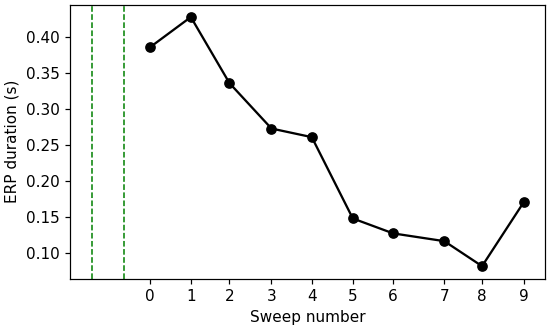

Text(0, 0.5, 'ERP duration (s)')

In [29]:
fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
for inji in subjects_data[subject][day]['inj_times']:
    ax.axvline(inji, color='g', linewidth=1.0, linestyle='dashed')
ax.plot(sweep_metrics_df['sweep_time'].values, sweep_metrics_df['all_duration'].values, color='k', marker='o')
ax.set_xticks(sweep_metrics_df['sweep_time'].values)
ax.set_xticklabels(sweep_metrics_df['sweep'].values)
ax.set_xlabel('Sweep number')
ax.set_ylabel('ERP duration (s)')